In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.mixture import GaussianMixture

In [ ]:
import pandas as pd

# Load the dataset
file_path = "/content/NGC 6752-result.csv"
df = pd.read_csv(file_path)


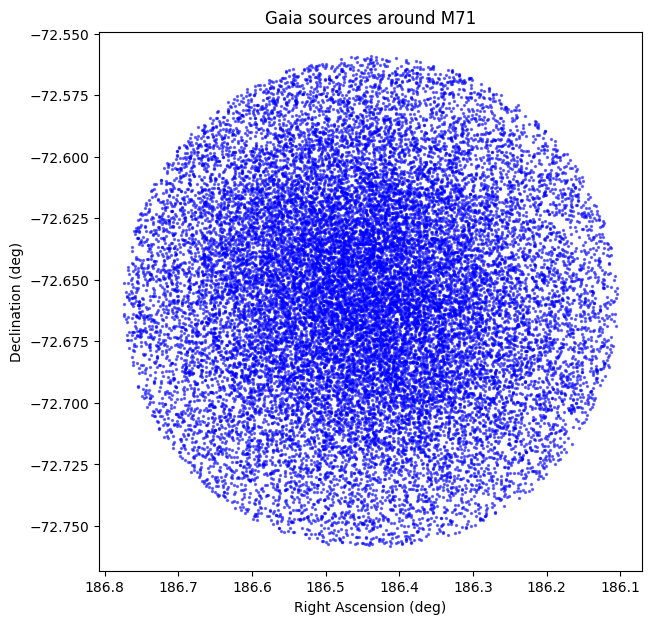

In [ ]:
# Plot
plt.figure(figsize=(7,7))
plt.scatter(df['ra'], df['dec'], s=2, color="blue", alpha=0.5)
plt.gca().invert_xaxis()
plt.xlabel("Right Ascension (deg)")
plt.ylabel("Declination (deg)")
plt.title("Gaia sources around M71")
plt.show()

In [ ]:
criteria = (
    (df['ruwe'] < 1.4) &
    (df['pmra_error'] < 0.5) &
    (df['pmdec_error'] < 0.5) &
    (df['astrometric_excess_noise_sig'] < 2) &
    #((df['parallax_over_error'])>1) &
    (df['astrometric_gof_al'] < 3) &
    #(df['phot_g_mean_mag'] > 10)&
    #(df['phot_g_mean_mag'] <20)&
    (df['visibility_periods_used'] > 10))

cleaned_df = df[criteria]
cleaned_df.to_csv('/content/Cleaned_file.csv', index=False)
print("Filtered data saved to /Cleaned_file.csv")

Filtered data saved to /Cleaned_file.csv


In [ ]:
df = pd.read_csv('/content/Cleaned_file.csv')
print(df)

                        designation            source_id          ra  \
0      Gaia DR3 6632372787219990784  6632372787219990784  287.710149   
1      Gaia DR3 6632372821577755264  6632372821577755264  287.698447   
2      Gaia DR3 6638377392022465792  6638377392022465792  287.740793   
3      Gaia DR3 6638377387722691584  6638377387722691584  287.740431   
4      Gaia DR3 6632372821583981056  6632372821583981056  287.691429   
...                             ...                  ...         ...   
18729  Gaia DR3 6638382236744509824  6638382236744509824  287.783525   
18730  Gaia DR3 6632323790230683264  6632323790230683264  287.611694   
18731  Gaia DR3 6632389928431673856  6632389928431673856  287.538859   
18732  Gaia DR3 6638393919050788992  6638393919050788992  287.709603   
18733  Gaia DR3 6638378388447683840  6638378388447683840  287.942047   

       ra_error        dec  dec_error  parallax  parallax_error  \
0      0.036776 -59.990793   0.044912  0.345379        0.059572   
1

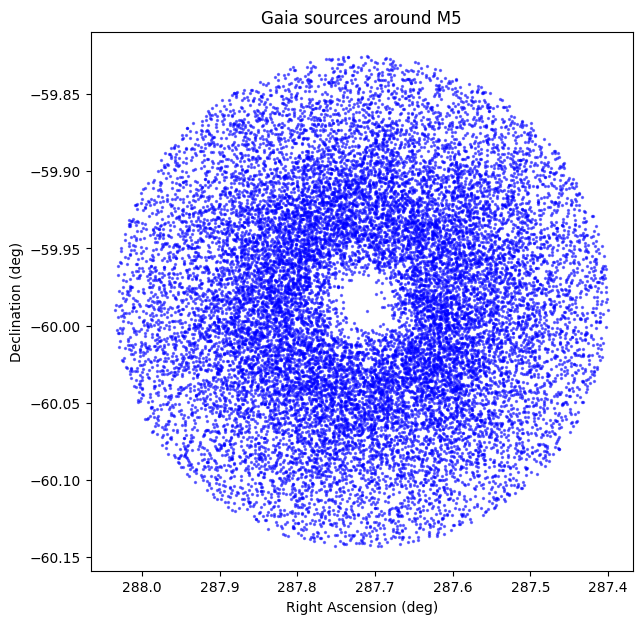

In [ ]:
# Plot
plt.figure(figsize=(7,7))
plt.scatter(df['ra'], df['dec'], s=2, color="blue", alpha=0.5)

plt.gca().invert_xaxis()  # standard for sky maps
plt.xlabel("Right Ascension (deg)")
plt.ylabel("Declination (deg)")
plt.title("Gaia sources around M5")
plt.show()

/tmp/ipython-input-3426214954.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.working_data.loc[:, 'PMemb'] = probs[:, 1]
/tmp/ipython-input-3426214954.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.working_data.loc[:, 'gmm_label'] = labels


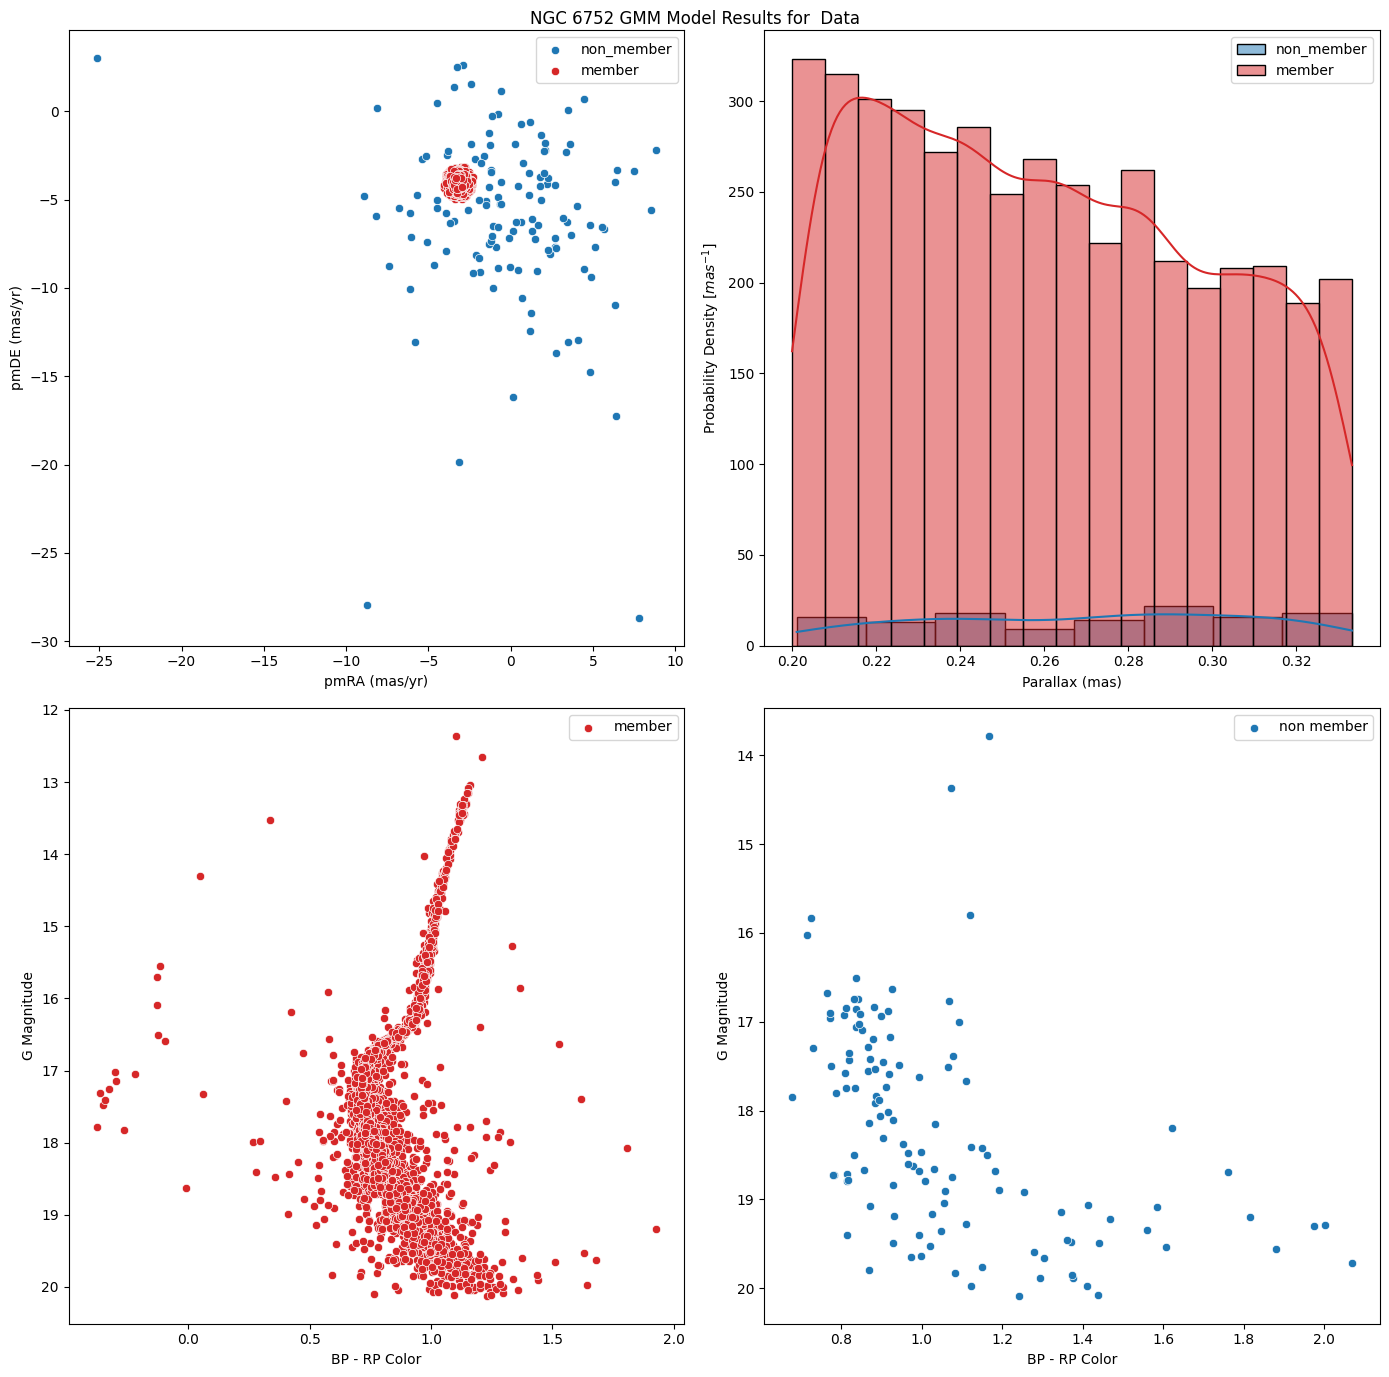

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Run_GMM_Model class
class Run_GMM_Model:
    def __init__(self, data, distance):
        self.data = data
        self.distance_lit = distance
        self.best_half_width = None
        self.best_member_cutoff = None

    def get_working_data(self, half_width):
        filter = abs(self.data.distance_pc - self.distance_lit) < half_width
        working_data = self.data.loc[filter, :]
        return working_data

    def get_member(self, half_width, feature_columns, cutoff=0.97, random_state=42):
        self.feature_columns = feature_columns
        self.working_data = self.get_working_data(half_width)
        features = self.working_data.loc[:, feature_columns].dropna()

        if len(features) < 2:
            raise ValueError('Less than two stars in the data')

        scaled_features = pd.DataFrame()
        for column in features.columns:
            scaled_features[column] = (features[column] - np.median(features[column])) / np.std(features[column])

        gmm = GaussianMixture(n_components=2, n_init=5, random_state=random_state)
        gmm.fit(scaled_features)

        labels = gmm.predict(scaled_features)
        probs = gmm.predict_proba(scaled_features)

        self.working_data.loc[:, 'PMemb'] = probs[:, 1]
        self.working_data.loc[:, 'gmm_label'] = labels

        non_member_ind = self.working_data.loc[:, 'PMemb'] <= (1 - cutoff)
        non_member = self.working_data.loc[non_member_ind, :]

        member_ind = self.working_data.loc[:, 'PMemb'] >= cutoff
        member = self.working_data.loc[member_ind, :]

        # Flip if cluster members are more scattered than field
        if member[feature_columns].std().mean() > non_member[feature_columns].std().mean():
            self.working_data.loc[:, 'PMemb'] = probs[:, 0]
            self.working_data.loc[:, 'gmm_label'] = 1 - labels

            non_member_ind = self.working_data.loc[:, 'PMemb'] <= (1 - cutoff)
            non_member = self.working_data.loc[non_member_ind, :]

            member_ind = self.working_data.loc[:, 'PMemb'] >= cutoff
            member = self.working_data.loc[member_ind, :]

        self.member, self.non_member, self.gmm = member, non_member, gmm

    def get_MSS_metric(self, epsilon=1e-7):
        if len(self.member) < 2 or len(self.non_member) < 2:
            return 0

        metric = np.zeros(len(self.feature_columns))
        for i in range(len(self.feature_columns)):
            feature_i = self.feature_columns[i]
            metric[i] = (np.std(self.non_member[feature_i]) - np.std(self.member[feature_i])) / max(
                np.std(self.member[feature_i]), np.std(self.non_member[feature_i]), epsilon)

        self.mss_metric = metric.mean()
        return self.mss_metric

    def visualize_member(self, title=None):
        plt.figure(figsize=(14, 14))

        if title:
            plt.suptitle(title)

        plt.subplot(221)
        sns.scatterplot(data=self.non_member, x='pmra', y='pmdec', label='non_member', color='tab:blue')
        sns.scatterplot(data=self.member, x='pmra', y='pmdec', label='member', color='tab:red')
        plt.xlabel('pmRA (mas/yr)')
        plt.ylabel('pmDE (mas/yr)')

        plt.subplot(222)
        sns.histplot(self.non_member.parallax, label='non_member', color='tab:blue', kde=True)
        sns.histplot(self.member.parallax, label='member', color='tab:red', kde=True)
        plt.xlabel('Parallax (mas)')
        plt.ylabel('Probability Density [$mas^{-1}$]')
        plt.legend()

        plt.subplot(223)
        sns.scatterplot(data=self.member, x='bp_rp', y='phot_g_mean_mag', color='tab:red', label='member')
        plt.gca().invert_yaxis()
        plt.ylabel('G Magnitude')
        plt.xlabel('BP - RP Color')

        plt.subplot(224)
        sns.scatterplot(data=self.non_member, x='bp_rp', y='phot_g_mean_mag', color='tab:blue', label='non member')
        plt.gca().invert_yaxis()
        plt.ylabel('G Magnitude')
        plt.xlabel('BP - RP Color')

        plt.tight_layout()
        plt.show()

#Load your data
file_path = '/content/Cleaned_file.csv'  # <- Change if needed
data = pd.read_csv(file_path)

# Calculate distance from parallax (Plx in milliarcseconds)
data = data[data['parallax'] > 0]  # remove stars with invalid parallax
data['distance_pc'] = 1000 / data['parallax']

# Known distance of the cluster in parsecs (can adjust)
distance_lit =4000
# Initialize the GMM model
gmm_model = Run_GMM_Model(data, distance_lit)

# Define the feature columns
feature_columns = ['pmra', 'pmdec', 'parallax']

# Run the GMM model
gmm_model.get_member(half_width =1000, feature_columns=feature_columns)

# Visualize the results
gmm_model.visualize_member(title='NGC 6752 GMM Model Results for  Data')
plt.savefig("NGC 6752")

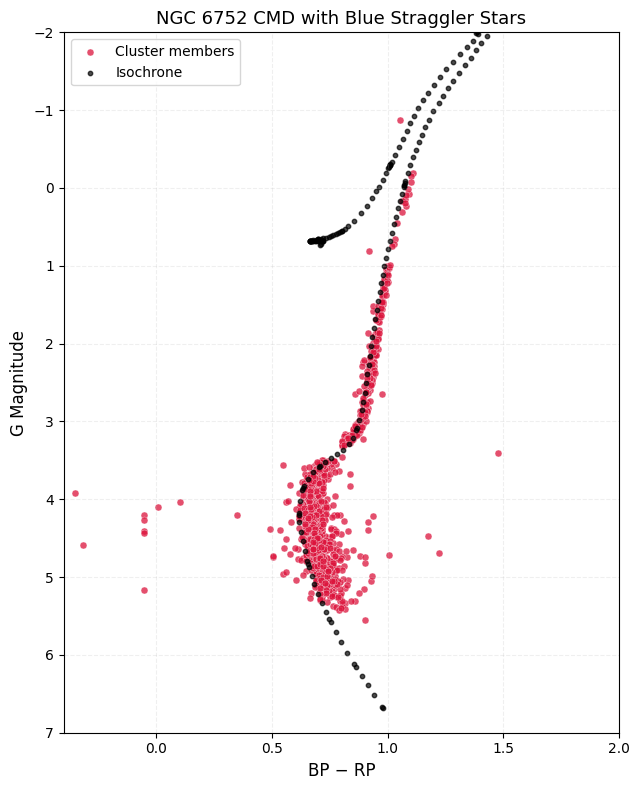

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = pd.read_csv('/content/NGC6752_Memeberdata.csv')
iso = pd.read_csv('/content/10.071_1.54_cleaned.txt', sep=r'\s+')

# Isochrone color
iso['BP_RP'] = iso['G_BPmag'] - iso['G_RPmag']

# ---- BSS SELECTION ----
bss = data[(data['BP_RP_CORR'] < 0.8) & (data['M_G_CORR'] < 3.5)]
non_bss = data.drop(bss.index)

# ---- PLOT ----
plt.figure(figsize=(6.5, 8))

# Normal cluster members
plt.scatter(
    non_bss['BP_RP_CORR'],
    non_bss['M_G_CORR'],
    s=25,
    c='crimson',
    edgecolors='white',
    linewidths=0.3,
    alpha=0.75,
    label='Cluster members'
)

# Blue Straggler Stars
#plt.scatter(
    #bss['BP_RP_CORR'],
    #bss['M_G_CORR'],
    #s=45,
    #c='royalblue',
    #edgecolors='black',
    #linewidths=0.6,
    #label='Blue Straggler Stars'
#)

# Isochrone as scatter
plt.scatter(
    iso['BP_RP'],
    iso['Gmag']+0.3,
    s=10,
    c='black',
    alpha=0.7,
    label='Isochrone'
)

# Axes
plt.gca().invert_yaxis()
plt.xlim(-0.4, 2.0)
plt.ylim(7.0, -2.0)

# Labels and title
plt.xlabel('BP − RP', fontsize=12)
plt.ylabel('G Magnitude', fontsize=12)
plt.title('NGC 6752 CMD with Blue Straggler Stars', fontsize=13)

# Grid and legend
plt.grid(alpha=0.2, linestyle='--')
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()



In [ ]:
# Filter the members
data1 = gmm_model.member

In [ ]:
# Save the non-member data to a CSV file
non_member_file_path = "/content/non_member_data.csv"
gmm_model.non_member.to_csv(non_member_file_path, index=False)

print(f"Non-member data saved to {non_member_file_path}")

In [ ]:
data1['distance_modulus'] = 5 * np.log10(data1['distance_pc']) - 5

/tmp/ipython-input-3604053693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['distance_modulus'] = 5 * np.log10(data1['distance_pc']) - 5


In [ ]:
# Save the member data/ to a CSV file
data1.to_csv('/content/NGC4372Memeberdata.csv', index=False)

print("Member data saved to /content/drive/My Drive/data1.csv")

Member data saved to /content/drive/My Drive/data1.csv


In [ ]:
import csv

input_path = '/content/NGC5272_Memeberdata.csv'
output_path = '/content/NGC5272_ascii_table.txt'

with open(input_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    rows = list(reader)

headers = rows[0]
ra_idx = headers.index('ra')
dec_idx = headers.index('dec')
size_idx = headers.index('distance_pc')

ascii_lines = []
ascii_lines.append("|  ra        |  dec       |  size   |")
ascii_lines.append("|  double    |  double    |  double |")
ascii_lines.append("|            |            |   deg   |")

for row in rows[1:]:
    try:
        ra = float(row[ra_idx])
        dec = float(row[dec_idx])
        size = float(row[size_idx])
        ascii_lines.append(f"  {ra:<11.6f}  {dec:<11.6f}  {size:<6.2f}")
    except ValueError:
        continue

with open(output_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(ascii_lines))

In [ ]:
df = pd.read_fwf('/content/extinction5272.tbl.txt')  # automatically detects fixed-width columns
df.to_csv('NGC_5272_EXTINCTION_CORREC.csv', index=False)


In [ ]:
#Extinction Corretion
file_path = '/content/NGC4372Memeberdata.csv' #UPLOAD THE FILE In the drive first
data2 = pd.read_csv(file_path)
data2['Av']=3.1*data2['Extinction'] #Rv=3.1
data2['A_G']=0.789*data2['Av'] #K from literature
data2['A_BP']=1.002*data2['Av']
data2['A_RP']=0.589*data2['Av']
data2['M_G_corr']=data2['phot_g_mean_mag']-data2['distance_modulus']-data2['A_G'] #Absolute magnitude with distance modulus correction
data2['M_BP_corr']=data2['phot_bp_mean_mag']-data2['distance_modulus']-data2['A_BP']
data2['M_RP_corr']=data2['phot_rp_mean_mag']-data2['distance_modulus']-data2['A_RP']
data2['bp_rp_corr'] = (data2['M_BP_corr']-data2['M_RP_corr']) #corrected bp-rp

KeyError: 'phot_bp_mean_mag'

In [ ]:
# Save the Extinction corrected to a CSV file
data2.to_csv('/content/Extinction_NGC5272_file.csv', index=False)
print("Member data saved to /content/ExtinctionNGC5272_file.csv")

Member data saved to /content/ExtinctionNGC5272_file.csv


In [ ]:
# Paper Method
med_ra=df['pmra'].median()
med_de=df['pmdec'].median()
df['mu_r']=(((df['pmra']-med_ra)**2)+((df['pmdec']-med_de)**2))**0.5
df['mu_r_std']=df['mu_r'].std()

Text(0.5, 0, 'Gmag')

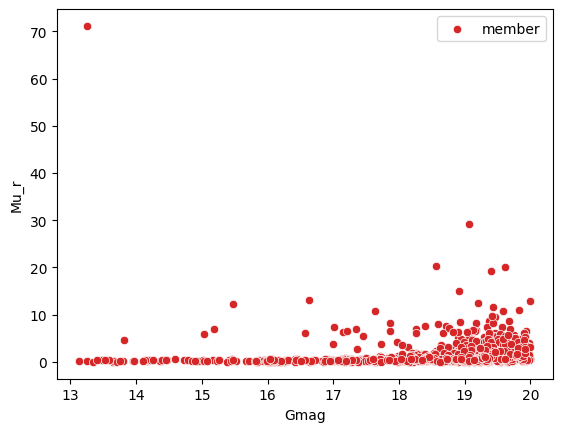

In [ ]:
sns.scatterplot(data=df, x='phot_g_mean_mag', y='mu_r', color='tab:red', label='member')
#plt.gca().invert_yaxis()
plt.ylabel('Mu_r')
plt.xlabel('Gmag')

In [ ]:
# Paper Method
med_plx=df['parallax'].median()
df['mu_plx']=(((df['parallax']-med_plx)**2))**0.5
df['mu_plx_std']=df['mu_plx'].std()

In [ ]:
df.to_csv('/content/NGC5904_Member.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
# 1. Parameters for binning
bin_size = 0.5
num_bins = 20

# 2. Define bin edges based on G magnitude
G_min = df['phot_g_mean_mag'].min()
G_max = G_min + bin_size * num_bins
bins = np.arange(G_min, G_max + bin_size, bin_size)

# 3. Compute median G_mag, median mu_R, and std(mu_R) in each bin
binned_stats = []
for i in range(len(bins)-1):
    bin_mask = (df['phot_g_mean_mag'] >= bins[i]) & (df['phot_g_mean_mag'] < bins[i+1])
    bin_data = df[bin_mask]

    if len(bin_data) > 0:
        G_median = bin_data['phot_g_mean_mag'].median()
        mu_median = bin_data['mu_r'].median()
        mu_std = bin_data['mu_r'].std()
        binned_stats.append([G_median, mu_median, mu_std])

binned_stats = np.array(binned_stats)
G_medians = binned_stats[:,0]
mu_medians = binned_stats[:,1]
mu_stds = binned_stats[:,2]

# 4. Create ±3σ points
mu_upper = mu_medians + 3*mu_stds
mu_lower = mu_medians - 3*mu_stds

# 5. Interpolation
interp_upper = interp1d(G_medians, mu_upper, kind='linear', fill_value='extrapolate')
interp_lower = interp1d(G_medians, mu_lower, kind='linear', fill_value='extrapolate')

# 6. Evaluate interpolated curve for all G_mag in the dataset
mu_upper_interp = interp_upper(df['phot_g_mean_mag'])
mu_lower_interp = interp_lower(df['phot_g_mean_mag'])

# 7. Keep only values within ±3σ of interpolation
mask = (df['mu_r'] >= mu_lower_interp) & (df['mu_r'] <= mu_upper_interp)
df_filtered = df[mask]

In [ ]:
# 1. Bin edges are same as before (based on G magnitude)
# You can reuse `bins` from previous step

# 2. Compute median G_mag, median parallax, and std(parallax) in each bin
binned_stats_parallax = []
for i in range(len(bins)-1):
    bin_mask = (df['phot_g_mean_mag'] >= bins[i]) & (df['phot_g_mean_mag'] < bins[i+1])
    bin_data = df[bin_mask]

    if len(bin_data) > 0:
        G_median = bin_data['phot_g_mean_mag'].median()
        parallax_median = bin_data['parallax'].median()
        parallax_std = bin_data['parallax'].std()
        binned_stats_parallax.append([G_median, parallax_median, parallax_std])

binned_stats_parallax = np.array(binned_stats_parallax)
G_medians = binned_stats_parallax[:,0]
parallax_medians = binned_stats_parallax[:,1]
parallax_stds = binned_stats_parallax[:,2]

# 3. Create ±3σ boundaries
parallax_upper = parallax_medians + 3*parallax_stds
parallax_lower = parallax_medians - 3*parallax_stds

# 4. Interpolation
interp_upper_parallax = interp1d(G_medians, parallax_upper, kind='linear', fill_value='extrapolate')
interp_lower_parallax = interp1d(G_medians, parallax_lower, kind='linear', fill_value='extrapolate')

# 5. Evaluate interpolated curve for all G_mag in the dataset
parallax_upper_interp = interp_upper_parallax(df['phot_g_mean_mag'])
parallax_lower_interp = interp_lower_parallax(df['phot_g_mean_mag'])

# 6. Keep only values within ±3σ boundaries
mask_parallax = (df['parallax'] >= parallax_lower_interp) & (df['parallax'] <= parallax_upper_interp)
df_filtered_parallax = df[mask_parallax]

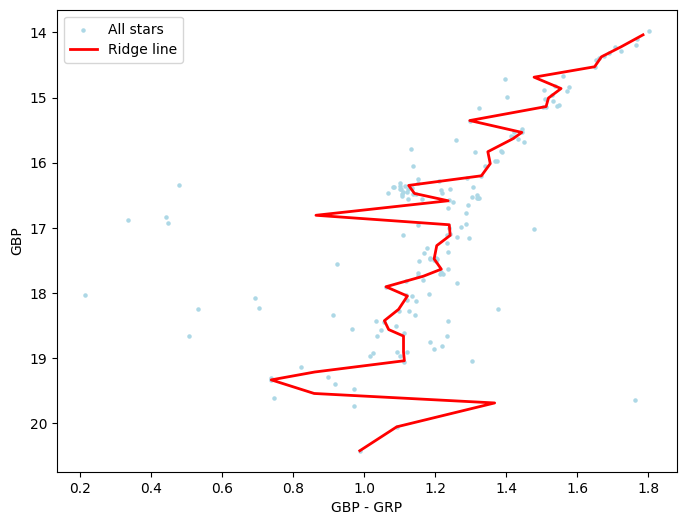

/tmp/ipython-input-3823781087.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color_residual'] = df['bp_rp'] - ridge_color


In [ ]:
df= gmm_model.member
bin_size = (df['phot_bp_mean_mag'].max() - df['phot_bp_mean_mag'].min()) / 40
bins = np.arange(df['phot_bp_mean_mag'].min(), df['phot_bp_mean_mag'].max() + bin_size, bin_size)
ridge_line = []
for i in range(len(bins)-1):
    bin_mask = (df['phot_bp_mean_mag'] >= bins[i]) & (df['phot_bp_mean_mag'] < bins[i+1])
    bin_data = df[bin_mask]

    if len(bin_data) > 0:
        mag_median = bin_data['phot_bp_mean_mag'].median()
        color_median = bin_data['bp_rp'].median()
        ridge_line.append([mag_median, color_median])

ridge_line = np.array(ridge_line)
plt.figure(figsize=(8,6))
plt.scatter(df['bp_rp'], df['phot_bp_mean_mag'], s=5, color='lightblue', label='All stars')
plt.plot(ridge_line[:,1], ridge_line[:,0], color='red', lw=2, label='Ridge line')
plt.gca().invert_yaxis()  # Magnitude axis inverted
plt.xlabel('GBP - GRP')
plt.ylabel('GBP')
plt.legend()
plt.show()
ridge_line = np.array(ridge_line)

# Interpolate ridge-line color at each star's magnitude
ridge_color = np.interp(df['phot_bp_mean_mag'], ridge_line[:,0], ridge_line[:,1])

# Residual color = actual color - ridge-line color
df['color_residual'] = df['bp_rp'] - ridge_color



In [ ]:
ridge_df = pd.DataFrame(ridge_line, columns=['phot_bp_mean_mag', 'bp_rp'])
ridge_df.to_csv('ridge_line.csv', index=False)

In [ ]:
ms_mask = (df['phot_bp_mean_mag'] >= ridge_line[:,0].min()) & (df['phot_bp_mean_mag'] <= ridge_line[:,0].min() + 1.5)
sgb_mask = (df['phot_bp_mean_mag'] > ridge_line[:,0].min() + 1.5) & (df['phot_bp_mean_mag'] <= ridge_line[:,0].min() + 2.5)
rgb_mask = (df['phot_bp_mean_mag'] > ridge_line[:,0].min() + 2.5)
ms_width = df.loc[ms_mask, 'color_residual'].std()
sgb_width = df.loc[sgb_mask, 'color_residual'].std()
rgb_width = df.loc[rgb_mask, 'color_residual'].std()

ms_width *= 2
sgb_width *= 2
rgb_width *= 2

print(ms_width, sgb_width, rgb_width)


0.09544660963837813 0.25807337230846816 0.44580954086923535


In [ ]:
import numpy as np
import pandas as pd

def select_cmd_branches(df, num_bins=40, width_factor=2):

    df = df.copy()
    df['color'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']


    bin_edges = np.linspace(df['phot_bp_mean_mag'].min(),
                            df['phot_bp_mean_mag'].max(),
                            num_bins+1)
    ridge_line = []
    for i in range(len(bin_edges)-1):
        bin_mask = (df['phot_bp_mean_mag'] >= bin_edges[i]) & (df['phot_bp_mean_mag'] < bin_edges[i+1])
        bin_data = df[bin_mask]
        if len(bin_data) > 0:
            median_mag = bin_data['phot_bp_mean_mag'].median()
            median_color = bin_data['bp_rp'].median()
            ridge_line.append([median_mag, median_color])
    ridge_line = np.array(ridge_line)

    ridge_color = np.interp(df['phot_bp_mean_mag'], ridge_line[:,0], ridge_line[:,1])
    df['color_residual'] = df['bp_rp'] - ridge_color

    mag_min = ridge_line[:,0].min()
    mag_max = ridge_line[:,0].max()
    ms_mask_range = (df['phot_bp_mean_mag'] <= mag_min + (mag_max - mag_min)*0.4)
    sgb_mask_range = (df['phot_bp_mean_mag'] > mag_min + (mag_max - mag_min)*0.4) & \
                     (df['phot_bp_mean_mag'] <= mag_min + (mag_max - mag_min)*0.7)
    rgb_mask_range = (df['phot_bp_mean_mag'] > mag_min + (mag_max - mag_min)*0.7)


    ms_width = df.loc[ms_mask_range, 'color_residual'].std() * width_factor
    sgb_width = df.loc[sgb_mask_range, 'color_residual'].std() * width_factor
    rgb_width = df.loc[rgb_mask_range, 'color_residual'].std() * width_factor

    widths = {'MS': ms_width, 'SGB': sgb_width, 'RGB': rgb_width}

    ms_mask = ms_mask_range & (np.abs(df['color_residual']) <= ms_width)
    sgb_mask = sgb_mask_range & (np.abs(df['color_residual']) <= sgb_width)
    rgb_mask = rgb_mask_range & (np.abs(df['color_residual']) <= rgb_width)

    ms_stars = df[ms_mask]
    sgb_stars = df[sgb_mask]
    rgb_stars = df[rgb_mask]

    return ridge_line, ms_stars, sgb_stars, rgb_stars, widths

In [ ]:
ridge_line, ms_stars, sgb_stars, rgb_stars, widths = select_cmd_branches(df)

print("Color widths:", widths)
print("MS stars:", len(ms_stars))
print("SGB stars:", len(sgb_stars))
print("RGB stars:", len(rgb_stars))


Color widths: {'MS': 0.21190971966139918, 'SGB': 0.43388958544981054, 'RGB': 0.41534156170710995}
MS stars: 57
SGB stars: 60
RGB stars: 33


In [ ]:
import matplotlib.pyplot as plt

def plot_cmd_with_ridgeline(df, ridge_line, ms_stars, sgb_stars, rgb_stars, widths):
    """
    Plot CMD with ridge-line and ±width bands for MS, SGB, RGB.

    Parameters:
    df : pandas.DataFrame
        Full dataset with 'phot_bp_mean_mag' and 'bp_rp' columns.
    ridge_line : np.array
        Nx2 array of median GBP magnitude and median color (bp_rp)
    ms_stars, sgb_stars, rgb_stars : pandas.DataFrame
        Subsets of stars for each branch
    widths : dict
        Color widths for each branch
    """

    plt.figure(figsize=(8,6))


    plt.scatter(df['bp_rp'], df['phot_bp_mean_mag'], s=5, color='lightgray', label='All stars')
    plt.scatter(ms_stars['bp_rp'], ms_stars['phot_bp_mean_mag'], s=10, color='blue', label='MS')
    plt.scatter(sgb_stars['bp_rp'], sgb_stars['phot_bp_mean_mag'], s=10, color='green', label='SGB')
    plt.scatter(rgb_stars['bp_rp'], rgb_stars['phot_bp_mean_mag'], s=10, color='red', label='RGB')

    plt.plot(ridge_line[:,1], ridge_line[:,0], color='black', lw=1.5, label='Ridge-line')
    plt.fill_betweenx(ridge_line[:,0], ridge_line[:,1]-widths['MS'], ridge_line[:,1]+widths['MS'],
                      color='blue', alpha=0.1)
    plt.fill_betweenx(ridge_line[:,0], ridge_line[:,1]-widths['SGB'], ridge_line[:,1]+widths['SGB'],
                      color='green', alpha=0.1)
    plt.fill_betweenx(ridge_line[:,0], ridge_line[:,1]-widths['RGB'], ridge_line[:,1]+widths['RGB'],
                      color='red', alpha=0.1)

    plt.gca().invert_yaxis()
    plt.xlabel('BP - RP')
    plt.ylabel('GBP magnitude')
    plt.title('CMD with Ridge-line and Branch Selection')
    plt.legend()
    plt.show()

In [ ]:
df = df.copy()
df['color'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']
num_bins = 40
bin_edges = np.linspace(df['phot_bp_mean_mag'].min(),
                        df['phot_bp_mean_mag'].max(),
                        num_bins+1)
ridge_line = []
for i in range(len(bin_edges)-1):
    mask = (df['phot_bp_mean_mag'] >= bin_edges[i]) & (df['phot_bp_mean_mag'] < bin_edges[i+1])
    bin_data = df[mask]
    if len(bin_data) > 0:
        median_mag = bin_data['phot_bp_mean_mag'].median()
        median_color = bin_data['color'].median()
        ridge_line.append([median_mag, median_color])
ridge_line = np.array(ridge_line)


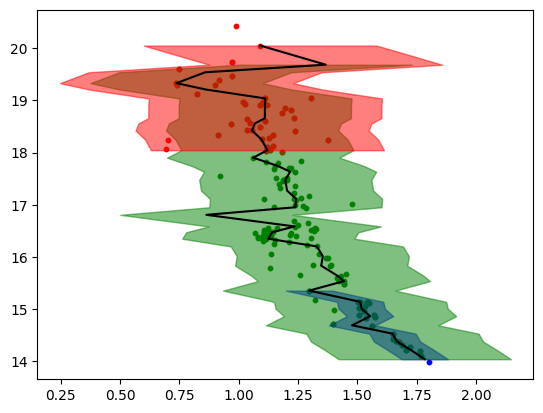

In [ ]:
ridge_color = np.interp(df['phot_bp_mean_mag'], ridge_line[:,0], ridge_line[:,1])
df['color_residual'] = df['color'] - ridge_color

ms_mag_max = 15.5
sgb_mag_min, sgb_mag_max = 14, 20
rgb_mag_min = 18

ms_mask = (df['phot_bp_mean_mag'] <= ms_mag_max)
sgb_mask = (df['phot_bp_mean_mag'] > sgb_mag_min) & (df['phot_bp_mean_mag'] <= sgb_mag_max)
rgb_mask = (df['phot_bp_mean_mag'] > rgb_mag_min)

width_factor = 2
ms_width = df.loc[ms_mask, 'color_residual'].std() * width_factor
sgb_width = df.loc[sgb_mask, 'color_residual'].std() * width_factor
rgb_width = df.loc[rgb_mask, 'color_residual'].std() * width_factor

ms_stars = df[ms_mask & (np.abs(df['color_residual']) <= ms_width)]
sgb_stars = df[sgb_mask & (np.abs(df['color_residual']) <= sgb_width)]
rgb_stars = df[rgb_mask & (np.abs(df['color_residual']) <= rgb_width)]


plt.scatter(ms_stars['bp_rp'], ms_stars['phot_bp_mean_mag'], s=10, color='blue', label='MS')
plt.scatter(sgb_stars['bp_rp'], sgb_stars['phot_bp_mean_mag'], s=10, color='green', label='SGB')
plt.scatter(rgb_stars['bp_rp'], rgb_stars['phot_bp_mean_mag'], s=10, color='red', label='RGB')


plt.plot(ridge_line[:,1], ridge_line[:,0], color='black', lw=1.5, label='Ridge-line')
plt.fill_betweenx(ridge_line[:,0], ridge_line[:,1]-ms_width, ridge_line[:,1]+ms_width,
                  where=(ridge_line[:,0] <= ms_mag_max), color='blue', alpha=0.5)
plt.fill_betweenx(ridge_line[:,0], ridge_line[:,1]-sgb_width, ridge_line[:,1]+sgb_width,
                  where=(ridge_line[:,0] > sgb_mag_min) & (ridge_line[:,0] <= sgb_mag_max),
                  color='green', alpha=0.5)
plt.fill_betweenx(ridge_line[:,0], ridge_line[:,1]-rgb_width, ridge_line[:,1]+rgb_width,
                  where=(ridge_line[:,0] > rgb_mag_min), color='red', alpha=0.5)


MEHTOD OF SELECTING BSS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize

def load_data(gaia_file, iso_file):
    """Load Gaia member and isochrone data."""
    gaia = pd.read_csv(gaia_file)
    if 'bp' not in gaia.columns or 'bp_rp' not in gaia.columns:
        raise ValueError("Gaia file must have columns: bp, bp_rp")

    iso = pd.read_csv(iso_file, comment='#', delim_whitespace=True)
    iso['bp_rp_iso'] = iso['G_Bpmag'] - iso['G_Rpmag']
    iso['bp_iso'] = iso['G_Bpmag']
    iso = iso[['bp_rp_iso', 'bp_iso']].dropna().sort_values('bp_rp_iso')

    return gaia, iso


def fit_isochrone(gaia, iso):
    """Fit isochrone by shifting in color and magnitude (minimize RMS)."""
    def loss(params):
        dc, dm = params
        shifted = iso.copy()
        shifted['bp_rp_iso'] += dc
        shifted['bp_iso'] += dm
        f_iso = interp1d(shifted['bp_rp_iso'], shifted['bp_iso'], fill_value="extrapolate")
        model_bp = f_iso(gaia['bp_rp'])
        return np.nanmean((gaia['bp'] - model_bp) ** 2)

    res = minimize(loss, x0=(0, 0), method='Powell')
    dc, dm = res.x
    iso['bp_rp_iso'] += dc
    iso['bp_iso'] += dm
    print(f" Best shift: Δcolor={dc:.3f}, Δmag={dm:.3f}")
    return iso


def find_msto(iso):
    color, mag = iso['bp_rp_iso'].values, iso['bp_iso'].values
    slopes = np.gradient(mag, color)
    idx = np.argmax(np.abs(slopes))
    return color[idx], mag[idx]


def select_bss(gaia, msto_color, msto_mag):
    below = gaia[gaia['bp'] > msto_mag]
    sigma_color = below['bp_rp'].std()
    sigma_mag = below['bp'].std()

    blue_limit = msto_color - 3 * sigma_color
    bright_limit = msto_mag - 4 * sigma_mag
    upper_mag_cut = msto_mag - 2
    hb_cut = msto_color - 0.5  # avoid HB stars

    mask = (
        (gaia['bp_rp'] <= blue_limit) &
        (gaia['bp_rp'] >= hb_cut) &
        (gaia['bp'] <= upper_mag_cut) &
        (gaia['bp'] >= bright_limit)
    )

    return gaia[mask]


def main(gaia_file, iso_file, output_file="BSS_output.csv"):
    gaia, iso = load_data(gaia_file, iso_file)
    iso_fit = fit_isochrone(gaia, iso)
    msto_color, msto_mag = find_msto(iso_fit)
    bss = select_bss(gaia, msto_color, msto_mag)
    bss.to_csv(output_file, index=False)
    print(f"\n✅ {len(bss)} Blue Straggler Stars saved → {output_file}")

    # Plot CMD
    plt.figure(figsize=(6, 8))
    plt.scatter(gaia['bp_rp'], gaia['bp'], s=8, alpha=0.5, color='gray', label='Members')
    plt.plot(iso_fit['bp_rp_iso'], iso_fit['bp_iso'], color='red', lw=2, label='Best-fit Isochrone')
    plt.scatter(bss['bp_rp'], bss['bp'], s=30, color='blue', edgecolor='k', label='BSS')
    plt.scatter([msto_color], [msto_mag], s=80, color='gold', marker='*', label='MSTO')
    plt.gca().invert_yaxis()
    plt.xlabel("BP - RP")
    plt.ylabel("BP magnitude")
    plt.legend()
    plt.title("Blue Straggler Selection (Gaia + PARSEC 3.8)")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize


def load_gaia(file):
    df = pd.read_csv(file)
    if not {'bp', 'bp_rp'}.issubset(df.columns):
        raise ValueError("Gaia file must contain columns 'bp' and 'bp_rp'")
    return df.dropna(subset=['bp', 'bp_rp']).sort_values('bp')
def load_isochrone(file, distance_pc=4000):
    iso = pd.read_csv(file, sep=r"\s+", comment="#")
    if not {'G_BPmag', 'G_RPmag'}.issubset(iso.columns):
        raise ValueError("Isochrone must have G_BPmag and G_RPmag columns")
    iso['bp_rp_iso'] = iso['G_BPmag'] - iso['G_RPmag']
    iso['bp_iso'] = iso['G_BPmag'] + (5 * np.log10(distance_pc) - 5)
    return iso[['bp_rp_iso', 'bp_iso']].dropna().sort_values('bp_rp_iso')


def make_ridgeline(gaia_df, nbins=40):
    bins = np.linspace(gaia_df['bp'].min(), gaia_df['bp'].max(), nbins)
    bin_idx = np.digitize(gaia_df['bp'], bins)
    ridge = []
    for i in range(1, nbins):
        bin_data = gaia_df[bin_idx == i]
        if len(bin_data) > 5:
            ridge.append([np.median(bin_data['bp_rp']), np.median(bin_data['bp'])])
    return pd.DataFrame(ridge, columns=['bp_rp', 'bp'])


def fit_isochrone(ridge_df, iso_df):
    def loss(params):
        dcolor, dmag = params
        shifted = iso_df.copy()
        shifted['bp_rp_iso'] += dcolor
        shifted['bp_iso'] += dmag
        f_iso = interp1d(shifted['bp_rp_iso'], shifted['bp_iso'], fill_value="extrapolate")
        model_bp = f_iso(ridge_df['bp_rp'])
        return np.nanmean((ridge_df['bp'] - model_bp)**2)
    res = minimize(loss, x0=(0, 0), method='Powell')
    dcolor, dmag = res.x
    iso_df['bp_rp_iso'] += dcolor
    iso_df['bp_iso'] += dmag
    return iso_df, dcolor, dmag


def find_msto(iso_df):
    colors, mags = iso_df['bp_rp_iso'].values, iso_df['bp_iso'].values
    slopes = np.gradient(mags, colors)
    idx = np.argmax(np.abs(slopes))
    return colors[idx], mags[idx]

def compute_sigmas(gaia_df, msto_mag):
    below = gaia_df[gaia_df['bp'] > msto_mag].sort_values('bp')
    bins = np.array_split(below, 10)
    largest_bin = max(bins, key=len)
    sigma_color = largest_bin['bp_rp'].std()

    sgb = gaia_df[(gaia_df['bp'] < msto_mag + 0.3) & (gaia_df['bp'] > msto_mag - 0.3)]
    sigma_mag = sgb['bp'].std()
    return sigma_color, sigma_mag


def classify_stragglers(gaia_df, msto_color, msto_mag, sigma_color, sigma_mag):
    blue_limit = msto_color - 3*sigma_color
    bright_limit = msto_mag - 4*sigma_mag
    upper_mag_cut = msto_mag - 2
    hb_cut = msto_color - 0.5


    selection = gaia_df[
        (gaia_df['bp_rp'] >= blue_limit) &
        (gaia_df['bp_rp'] <= msto_color + 0.5) &
        (gaia_df['bp'] <= upper_mag_cut) &
        (gaia_df['bp'] >= bright_limit)
    ].copy()

    selection['Type'] = 'Unclassified'
    selection.loc[selection['bp_rp'] < msto_color, 'Type'] = 'BSS'
    red_side = selection['bp_rp'] >= msto_color
    median_mag = selection['bp'].median()
    selection.loc[red_side & (selection['bp'] > median_mag), 'Type'] = 'YSS'
    selection.loc[red_side & (selection['bp'] <= median_mag), 'Type'] = 'RSS'

    return selection, blue_limit, bright_limit, upper_mag_cut, hb_cut

def find_bss(gaia_file, isochrone_file, output_file="/content/BSS_output.csv", distance_pc=4000):
    gaia_df = load_gaia(gaia_file)
    iso_df = load_isochrone(isochrone_file, distance_pc)
    ridge_df = make_ridgeline(gaia_df)

    iso_fit, dcolor, dmag = fit_isochrone(ridge_df, iso_df)
    print(f" Best-fit shift: color={dcolor:.3f}, mag={dmag:.3f}")

    msto_color, msto_mag = find_msto(iso_fit)
    sigma_color, sigma_mag = compute_sigmas(gaia_df, msto_mag)

    selection, blue_limit, bright_limit, upper_mag_cut, hb_cut = classify_stragglers(
        gaia_df, msto_color, msto_mag, sigma_color, sigma_mag
    )
    selection.to_csv(output_file, index=False)
    print(f" {len(selection[selection['Type']=='BSS'])} BSS, "
          f"{len(selection[selection['Type']=='YSS'])} YSS, "
          f"{len(selection[selection['Type']=='RSS'])} RSS saved to {output_file}")

    # --- Plot ---
    plt.figure(figsize=(7, 9))
    plt.scatter(gaia_df['bp_rp'], gaia_df['bp'], s=8, color='lightgray', alpha=0.5, label='Members')
    plt.plot(iso_fit['bp_rp_iso'], iso_fit['bp_iso'], c='red', lw=2, label='Best-fit Isochrone')
    plt.scatter(ridge_df['bp_rp'], ridge_df['bp'], s=20, color='green', label='Ridge-line')


    plt.scatter(msto_color, msto_mag, s=80, color='gold', edgecolor='k', zorder=5, label='MSTO')


    plt.scatter(
        selection.loc[selection['Type']=='BSS', 'bp_rp'],
        selection.loc[selection['Type']=='BSS', 'bp'],
        color='blue', s=35, edgecolor='k', label='BSS'
    )
    plt.scatter(
        selection.loc[selection['Type']=='YSS', 'bp_rp'],
        selection.loc[selection['Type']=='YSS', 'bp'],
        color='orange', s=35, edgecolor='k', label='YSS'
    )
    plt.scatter(
        selection.loc[selection['Type']=='RSS', 'bp_rp'],
        selection.loc[selection['Type']=='RSS', 'bp'],
        color='red', s=35, edgecolor='k', label='RSS'
    )


    rect = plt.Rectangle(
        (blue_limit, bright_limit),
        (hb_cut - blue_limit),
        (upper_mag_cut - bright_limit),
        fill=False, color='blue', lw=1.8, ls='--', label='BSS Selection Box'
    )
    plt.gca().add_patch(rect)

    plt.gca().invert_yaxis()
    plt.xlabel("BP - RP")
    plt.ylabel("BP magnitude")
    plt.legend(fontsize=8)
    plt.title("Blue, Yellow & Red Straggler Classification — Full Paper Method", fontsize=11)
    plt.show()

    return selection


In [ ]:
df= pd.read_csv("/content/FINAL_NGC5272_MEMBERDATA.csv")
df['bp'] = df['phot_bp_mean_mag']
df['bp_rp'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']
df.to_csv("/content/NGC5272_fixed.csv", index=False)


In [ ]:
input_file = "/content/10.071_1.54.txt"
output_file = "/content/10.071_1.54_cleaned.txt"

with open(input_file, 'r') as f:
    lines = f.readlines()
header_line = None
for i, line in enumerate(lines):
    if line.strip().startswith("# Zini"):
        header_line = i
        break

if header_line is None:
    raise ValueError("Couldn't find header line starting with '# Zini'")

header = lines[header_line].strip("#").strip()
columns = header.split()

data_lines = []
for line in lines[header_line + 1:]:
    if line.strip() and not line.strip().startswith("#"):
        # Normalize multiple spaces or tabs
        clean = " ".join(line.strip().split())
        data_lines.append(clean)

with open(output_file, "w") as f:
    f.write(" ".join(columns) + "\n")
    f.write("\n".join(data_lines))

print(f"✅ Cleaned isochrone saved → {output_file}")

✅ Cleaned isochrone saved → /content/10.071_1.54_cleaned.txt


In [ ]:
import pandas as pd
import numpy as np


input_file = "/content/10.06_1.50_cleaned.txt"
output_file = "/content/10.06_1.50_aligned.txt"
df = pd.read_csv(input_file, sep=r"\s+")

df = df.round(6)
df['G_Bpmag']=df['G_BPmag']
df['G_Rpmag']=df['G_RPmag']
df.to_csv(output_file, sep="\t", index=False)

print(f"Aligned isochrone file saved as {output_file}")
print("Columns:", len(df.columns))
df.head(3)


✅ Aligned isochrone file saved as /content/10.06_1.50_aligned.txt
Columns: 33


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag,G_Bpmag,G_Rpmag
0,0.000491,-1.5,10.06,0.09,1.081690,0.09,-3.183,3.4749,5.427,1,...,0.000024,0.000217,-1.0,0.000494,12.728,13.624,15.516,12.356,15.516,12.356
1,0.000491,-1.5,10.06,0.10,1.171106,0.10,-2.894,3.5162,5.349,1,...,0.000024,0.000217,-1.0,0.000494,12.005,12.678,13.996,11.563,13.996,11.563
2,0.000491,-1.5,10.06,0.12,1.319315,0.12,-2.608,3.5474,5.267,1,...,0.000024,0.000217,-1.0,0.000494,11.290,11.803,12.860,10.790,12.860,10.790


In [ ]:
pip install numpy pandas scipy


In [ ]:
import pandas as pd

msto = pd.read_csv('/content/MSTO_PHYSICAL_ PARAMETER', comment='#', delim_whitespace=True)
print(msto.columns.tolist())


['color,mag,Mass,Teff,logg,logL']


/tmp/ipython-input-1505385990.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  msto = pd.read_csv('/content/MSTO_PHYSICAL_ PARAMETER', comment='#', delim_whitespace=True)


In [ ]:
msto.columns = msto.columns.str.strip()

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator


iso = pd.read_csv('/content/ISOCHRONEDATA')
iso['color'] = iso['G_BPmag'] - iso['G_RPmag']
iso['mag'] = iso['Gmag']


params = ['Mass', 'logL', 'logTe', 'logg']
interp_funcs = {}
for p in params:
    interp_funcs[p] = LinearNDInterpolator(list(zip(iso['color'], iso['mag'])), iso[p])

bss = pd.read_csv('/content/NGC6752_Memeberdata.csv')
bss['color'] = bss['BP_RP_CORR']
bss['mag'] = bss['M_G_CORR']

for p in params:
    bss[p] = interp_funcs[p](bss['color'], bss['mag'])

bss['Teff'] = 10 ** bss['logTe']


bss[['color', 'mag', 'Mass', 'Teff', 'logg', 'logL']].to_csv('physical_parameters_NGC6752.csv', index=False)

print("Interpolation complete! Saved as bss_physical_parameters.csv")


✅ Interpolation complete! Saved as bss_physical_parameters.csv


DYNAMIC

In [ ]:
msto = pd.read_csv('/content/MSTO_PHYSICAL_ PARAMETER')
bss_ = pd.read_csv('/content/bss_physical_parameters.csv')
bss['mass_excess'] = (bss['Mass']-msto['Mass'])/msto['Mass']
bss.to_csv('BSS_EXCESS_MASS.csv', index=False)

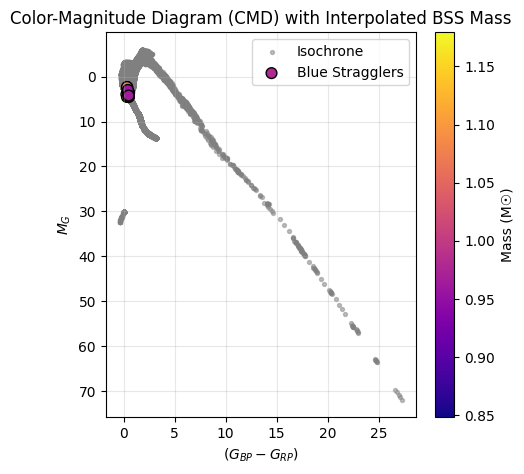

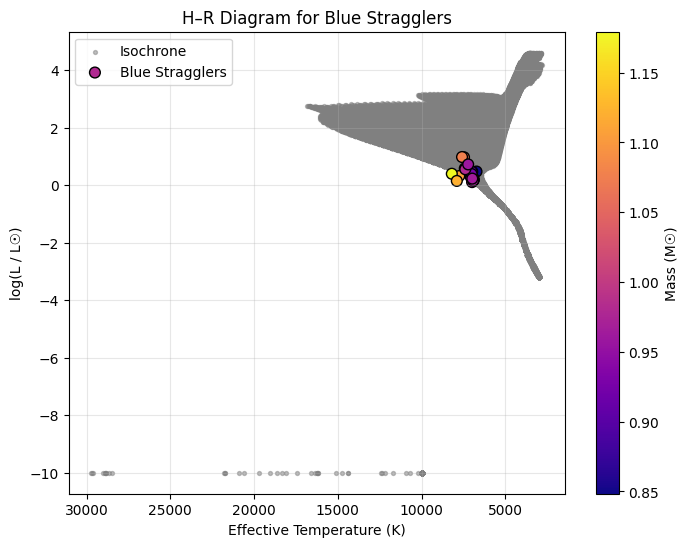

In [ ]:
plt.figure(figsize=(5, 5))
plt.gca().invert_yaxis()

plt.scatter(iso['color'], iso['mag'], s=8, color='gray', alpha=0.5, label='Isochrone')

sc = plt.scatter(bss['color'], bss['mag'], c=bss['Mass'], cmap='plasma', s=60, edgecolor='k', label='Blue Stragglers')

plt.colorbar(sc, label='Mass (M☉)')
plt.xlabel(r'$(G_{BP} - G_{RP})$')
plt.ylabel(r'$M_G$')
plt.title('Color-Magnitude Diagram (CMD) with Interpolated BSS Mass')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(10**iso['logTe'], iso['logL'], s=8, color='gray', alpha=0.5, label='Isochrone')
plt.scatter(bss['Teff'], bss['logL'], c=bss['Mass'], cmap='plasma', s=60, edgecolor='k', label='Blue Stragglers')
plt.gca().invert_xaxis()
plt.colorbar(label='Mass (M☉)')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('log(L / L☉)')
plt.title('H–R Diagram for Blue Stragglers')
plt.legend()
plt.grid(alpha=0.3)
plt.show()





In [ ]:
import pandas as pd

df = pd.read_csv('/content/NGC6205_Memeberdata.csv')
df = df.dropna(subset=['phot_g_mean_mag', 'phot_bp_mean_mag','phot_rp_mean_mag'])
df.to_csv('FINAL_NGC6205_MEMBERDATA.csv', index=False)

ROTATIONAL PROPERTIES

Columns: ['designation', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'visibility_periods_used', 'ruwe', 'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'radial_velocity', 'phot_variable_flag', 'non_single_star', 'has_xp_continuous', 'has_xp_sampled', 'has_rvs', 'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot', 'has_mcmc_msc', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'distance_gspphot', 'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot', 'target_id', 'target_ra', 'target_dec', 'target_parallax', 'target_pm_ra', 'target_pm_dec', 'target_radial_velocity', 'epoch', 'target_separation (deg)', 'distance_pc', 'PMe

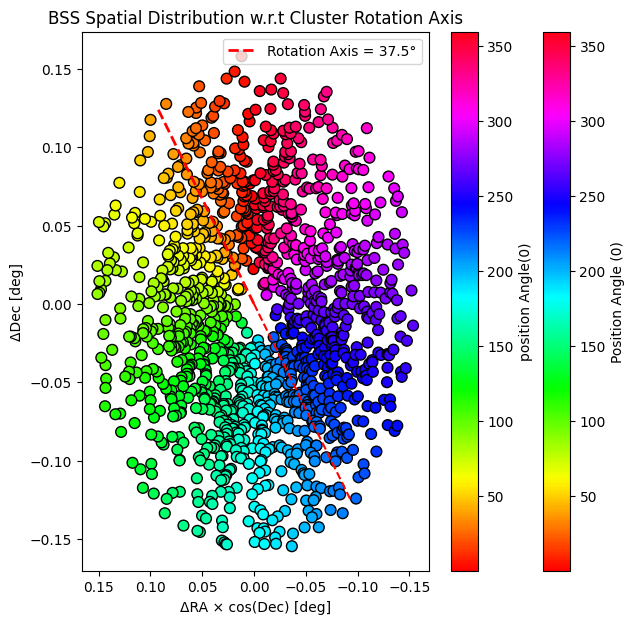

Bss alignment side
Side A    660
Side B    620
Name: count, dtype: int64


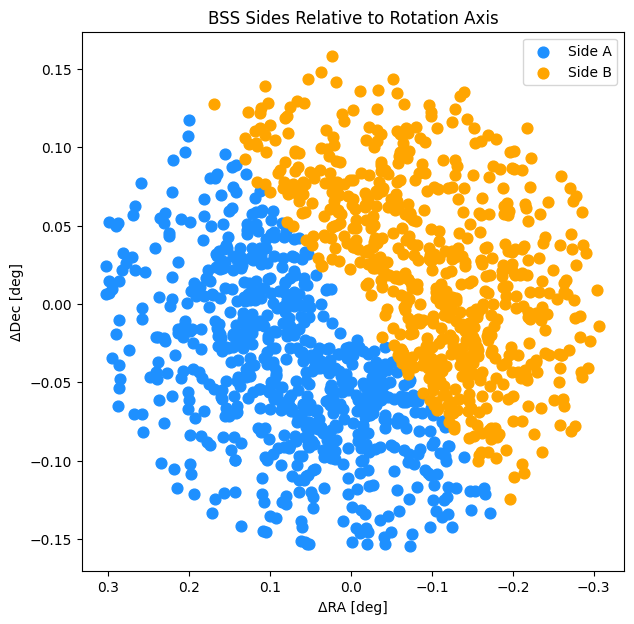

In [ ]:
# STEP 1. Importing imp libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# STEP 2. Loading BSS data
file_path = "/content/NGC6752_Memeberdata.csv"
data = pd.read_csv(file_path)
print("Columns:", data.columns.tolist())
data.head()

# STEP 3. Defining cluster center
RA_center = 287.717
Dec_center = -59.984

# STEP 4. Relative positions and position angles
RA = data['ra']
Dec = data['dec']

# Converting to radians for trig
ra_rad = np.deg2rad(RA)
dec_rad = np.deg2rad(Dec)
ra0 = np.deg2rad(RA_center)
dec0 = np.deg2rad(Dec_center)

# Computing delta_RA and delta_Dec in projected plane (arcsec or degrees)
delta_ra = (RA - RA_center) * np.cos(np.deg2rad(Dec_center))
delta_dec = Dec - Dec_center

# Computing position angle (θ) relative to cluster center
theta = np.degrees(np.arctan2(delta_ra, delta_dec))
theta = (theta + 360) % 360
data['pos_angle_deg'] = theta

# STEP 5. Ploting BSS distribution
rotation_axis = 37.5  # degrees (from your fit)
fig, ax = plt.subplots(figsize=(7,7))

sc = ax.scatter(delta_ra, delta_dec, c=theta, cmap='hsv', s=60, edgecolor='k')
plt.colorbar(sc, label='Position Angle (0)')
plt.colorbar(sc,label='position Angle(0)')

axis_x = [0, np.sin(np.radians(rotation_axis)) * max(abs(delta_ra))]
axis_y = [0, np.cos(np.radians(rotation_axis)) * max(abs(delta_dec))]
ax.plot(axis_x, axis_y, 'r--', lw=2, label=f'Rotation Axis = {rotation_axis}°')
ax.plot([-x for x in axis_x], [-y for y in axis_y], 'r--')
ax.set
ax.set_xlabel('ΔRA × cos(Dec) [deg]')
ax.set_ylabel('ΔDec [deg]')
ax.set_title('BSS Spatial Distribution w.r.t Cluster Rotation Axis')
ax.legend()
plt.gca().invert_xaxis()
plt.show()

# STEP 6. if BSS align with rotation
angle_diff = (theta - rotation_axis + 180) % 360 - 180
data['side'] = np.where(angle_diff > 0, 'Side A', 'Side B')
print("Bss alignment",data['side'].value_counts())

plt.figure(figsize=(7,7))
for side, color in zip(['Side A', 'Side B'], ['dodgerblue', 'orange']):
    subset = data[data['side'] == side]
    plt.scatter(subset['ra']-RA_center, subset['dec']-Dec_center, label=side, s=60, color=color)
plt.legend()
plt.xlabel('ΔRA [deg]')
plt.ylabel('ΔDec [deg]')
plt.title('BSS Sides Relative to Rotation Axis')
plt.gca().invert_xaxis()
plt.show()

Loading /content/NGC6752_Memeberdata.csv ...


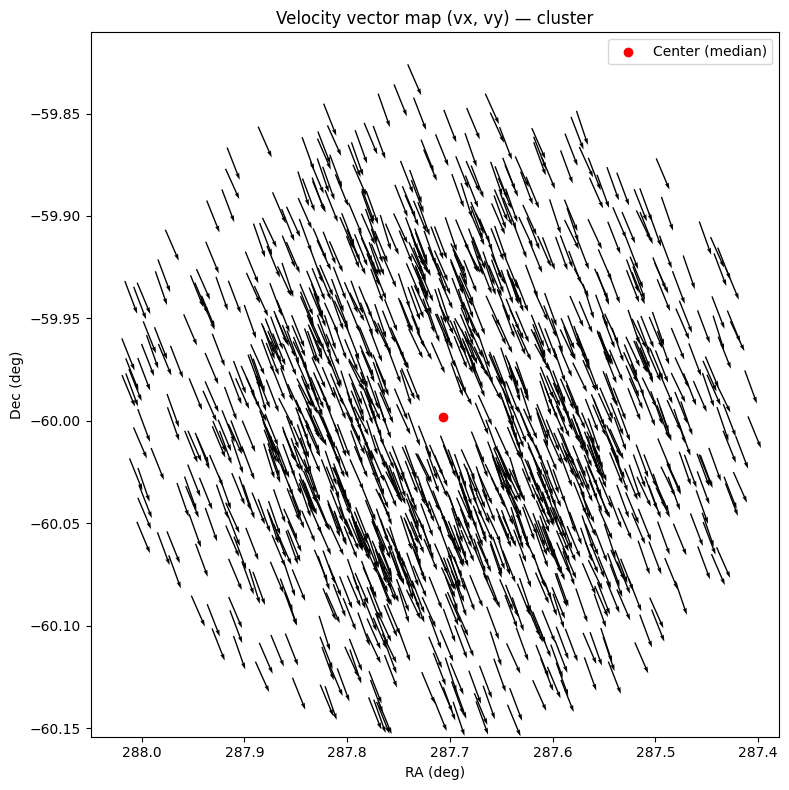

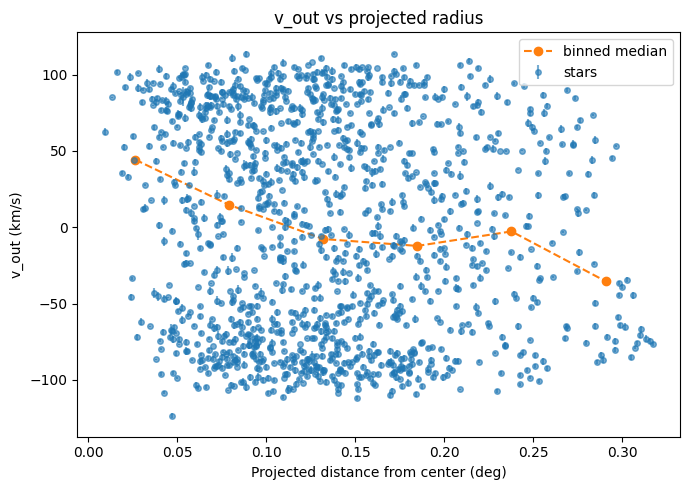

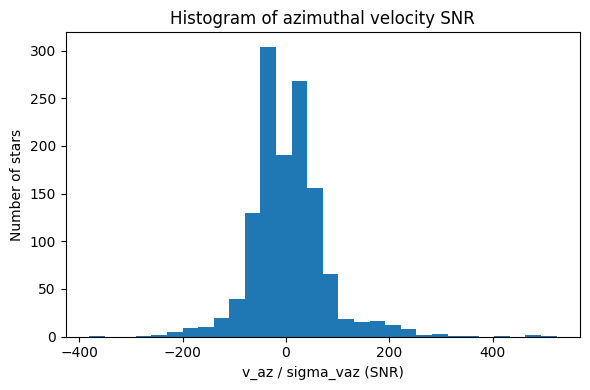

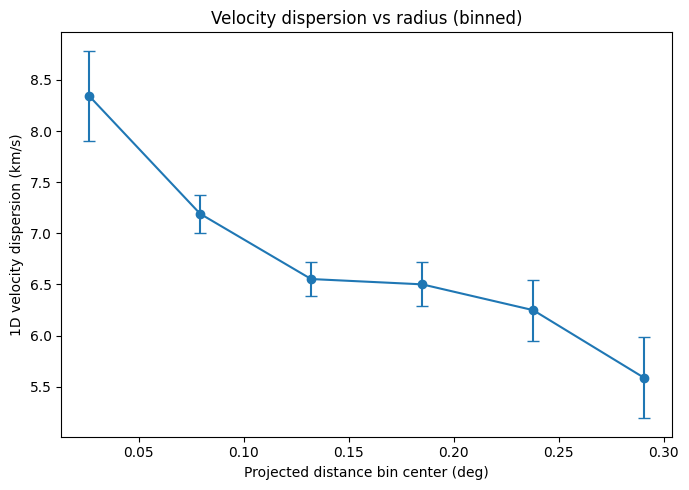

----- Summary -----
Number of stars: 1280
Median v_az: 2.1071 ± 3.7792 km/s  (bootstrap uncertainty)
MLE intrinsic mean velocity (mu_x, mu_y) [km/s]: [-59.83512082 -75.88823041]
MLE intrinsic covariance Sigma [km^2/s^2]:
 [[39.32089562 23.7428009 ]
 [23.7428009  53.67552947]]
Principal std devs (pc1, pc2) [km/s]: 8.444059038851218 4.657713176363436
Characteristic 1D dispersion s_1D: 6.8190 km/s
-------------------

===== Physical Interpretation (Auto-Generated) =====
1. Rotation (v_az): Median v_az = 2.11 ± 3.78 km/s → no detectable rotation.
   This value represents the mean tangential (azimuthal) motion of cluster members.

2. Expansion/Contraction:
   Correlation between v_out and radius = -0.11 (p = 0.000) → No significant expansion or contraction detected.

3. Velocity Dispersion: σ₁D = 6.82 km/s
   Interpretation: Moderately warm — possibly mass-segregated or starting to lose members.

4. Anisotropy: σ₁/σ₂ = 1.81 → Velocity distribution is anisotropic, suggesting tidal stretching

In [ ]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import inv, eigh
import os
import sys

# conversion factor: v(km/s) = 4.74047 * mu(mas/yr) / parallax(mas)
KAPPA = 4.74047

# ----------------------------- Utilities -----------------------------
def load_or_simulate(filename="cluster_data.csv", Nsim=300):
    if os.path.exists(filename):
        print(f"Loading {filename} ...")
        df = pd.read_csv(filename)
        needed = ['ra','dec','parallax','pmra','pmdec','pmra_error','pmdec_error']
        for c in needed:
            if c not in df.columns:
                raise ValueError(f"Required column '{c}' missing in {filename}")
        if 'pmra_pmdec_cov' not in df.columns:
            df['pmra_pmdec_cov'] = 0.0
        return df
    else:
        print(f"{filename} not found — generating simulated cluster data for demo.")
        np.random.seed(1)
        N = Nsim
        # cluster center (RA, Dec)
        ra0, dec0 = 287.717, -59.984
        # random positions
        theta = np.random.uniform(0, 2*np.pi, size=N)
        r_deg = np.random.exponential(scale=0.05, size=N)
        ras = ra0 + r_deg * np.cos(theta)
        decs = dec0 + r_deg * np.sin(theta)
        parallax = np.full(N, 1.0) + np.random.normal(0, 0.01, size=N)
        # intrinsic vx, vy (km/s)
        sigma_intr = 1.2
        vx_intr = np.random.normal(0, sigma_intr, size=N)
        vy_intr = np.random.normal(0, sigma_intr, size=N)
        # outward expansion term
        vout_extra = 0.6 * (r_deg / 0.1)
        vx_intr += vout_extra * np.cos(theta)
        vy_intr += vout_extra * np.sin(theta)
        # small rotation
        vrot = 0.3
        vx_intr += -vrot * np.sin(theta)
        vy_intr += vrot * np.cos(theta)
        pmra_true = vx_intr * parallax / KAPPA
        pmdec_true = vy_intr * parallax / KAPPA
        pmra_err = np.random.uniform(0.05, 0.25, size=N)
        pmdec_err = np.random.uniform(0.05, 0.25, size=N)
        pmra_obs = pmra_true + np.random.normal(0, pmra_err)
        pmdec_obs = pmdec_true + np.random.normal(0, pmdec_err)
        df = pd.DataFrame({
            'ra': ras, 'dec': decs, 'parallax': parallax,
            'pmra': pmra_obs, 'pmdec': pmdec_obs,
            'pmra_error': pmra_err, 'pmdec_error': pmdec_err,
            'pmra_pmdec_cov': np.zeros(N)
        })
        return df

def build_velocity_covariances(df):
    """
    Build per-star 2x2 measurement covariance matrices S_i in vx,vy (km^2/s^2)
    from pm errors/covariances: convert errors via KAPPA/parallax.
    Returns an array shape (N,2,2).
    """
    N = len(df)
    S = np.zeros((N,2,2))
    # convert pm errors -> velocity errors
    sigma_v_ra = KAPPA * df['pmra_error'].values / df['parallax'].values
    sigma_v_dec = KAPPA * df['pmdec_error'].values / df['parallax'].values
    df['pmra_pmdec_cov'] = 0.0
    cov_pm = df['pmra_pmdec_cov'].values if 'pmra_pmdec_cov' in df.columns else np.zeros(N)
    cov_v = KAPPA**2 * cov_pm / (df['parallax'].values**2)
    # fill matrices
    S[:,0,0] = sigma_v_ra**2
    S[:,1,1] = sigma_v_dec**2
    S[:,0,1] = cov_v
    S[:,1,0] = cov_v
    return S

# ---------------------- Core computations ----------------------
def compute_center_and_offsets(df):
    # center defined as median RA,Dec (simple / robust)
    alpha0 = np.median(df['ra'].values)
    delta0 = np.median(df['dec'].values)
    # small-angle angular offsets (radians); scale RA by cos(dec0)
    dalpha = np.deg2rad((df['ra'].values - alpha0) * np.cos(np.deg2rad(delta0)))
    ddelta = np.deg2rad(df['dec'].values - delta0)
    r_rad = np.sqrt(dalpha**2 + ddelta**2)
    theta = np.arctan2(ddelta, dalpha)  # angle measured from RA offset/Dec offset coordinate basis
    # also store simple projected distance in degrees for plotting
    r_deg = np.sqrt((df['ra'].values - alpha0)**2 + (df['dec'].values - delta0)**2)
    return alpha0, delta0, dalpha, ddelta, r_rad, r_deg, theta

def proper_motion_to_v(df):
    """
    Convert pmra, pmdec (mas/yr) and parallax (mas) to vx,vy (km/s) as in Kuhn et al.:
      vx = KAPPA * pmra / parallax
      vy = KAPPA * pmdec / parallax
    """
    vx = KAPPA * df['pmra'].values / df['parallax'].values
    vy = KAPPA * df['pmdec'].values / df['parallax'].values
    return vx, vy

def compute_vout_vaz(vx, vy, theta):
    # unit radial and azimuthal vectors (in the same coordinate basis as vx,vy)
    r_hat = np.vstack([np.cos(theta), np.sin(theta)]).T
    j_hat = np.vstack([-np.sin(theta), np.cos(theta)]).T
    vels = np.vstack([vx, vy]).T
    v_out = np.einsum('ij,ij->i', vels, r_hat)
    v_az  = np.einsum('ij,ij->i', vels, j_hat)
    return v_out, v_az, r_hat, j_hat

# ------------------- MLE for intrinsic Sigma -------------------
def mle_intrinsic_cov(vels, S_mats, verbose=False):
    """
    Maximize log-likelihood for intrinsic mean mu (2,) and intrinsic covariance Sigma (2x2)
    given heteroscedastic per-star covariance S_i.
    Returns mu_hat (2,), Sigma_hat (2x2).
    Parameterization: param = [mu_x, mu_y, ln_a, ln_c, b]
    Sigma = [[a, b], [b, c]] with a=exp(ln_a), c=exp(ln_c) to enforce positivity on diag.
    """
    N = vels.shape[0]
    # initial guesses
    mu0 = np.mean(vels, axis=0)
    sample_cov = np.cov(vels.T)
    mean_S = S_mats.mean(axis=0)
    init_cov = sample_cov - mean_S
    a0 = max(init_cov[0,0], 1e-2)
    c0 = max(init_cov[1,1], 1e-2)
    b0 = init_cov[0,1]
    p0 = np.array([mu0[0], mu0[1], np.log(a0), np.log(c0), b0])

    def neg_loglike(params):
        mu = params[0:2]
        a = np.exp(params[2])
        c = np.exp(params[3])
        b = params[4]
        Sigma = np.array([[a, b],[b, c]])
        # ensure PD
        if np.any(np.linalg.eigvalsh(Sigma) <= 0):
            return 1e12
        total = 0.0
        for i in range(N):
            Si = S_mats[i]
            Stot = Sigma + Si
            # guard
            try:
                invStot = inv(Stot)
                sign, logdet = np.linalg.slogdet(Stot)
                if sign <= 0:
                    return 1e12
            except np.linalg.LinAlgError:
                return 1e12
            diff = vels[i] - mu
            total += 0.5*(logdet + diff.T.dot(invStot).dot(diff))
        return total

    res = minimize(neg_loglike, p0, method='L-BFGS-B', options={'maxiter':2000})
    if not res.success:
        print("WARNING: MLE did not converge fully:", res.message)
    params = res.x
    mu_hat = params[0:2]
    Sigma_hat = np.array([[np.exp(params[2]), params[4]],[params[4], np.exp(params[3])]])
    return mu_hat, Sigma_hat

# -------------------------- Main analysis --------------------------
def main():
    # load or simulate
    df = load_or_simulate("/content/NGC6752_Memeberdata.csv")

    # compute center / offsets
    alpha0, delta0, dalpha, ddelta, r_rad, r_deg, theta = compute_center_and_offsets(df)
    df['r_deg'] = r_deg
    df['theta_rad'] = theta

    # convert pm -> velocities
    vx, vy = proper_motion_to_v(df)
    df['vx'] = vx
    df['vy'] = vy

    # build measurement covariances in velocity space
    S_mats = build_velocity_covariances(df)

    # compute v_out, v_az
    v_out, v_az, r_hat, j_hat = compute_vout_vaz(vx, vy, theta)
    df['v_out'] = v_out
    df['v_az'] = v_az

    # uncertainties on v_out and v_az via propagation: var = r_hat^T S_i r_hat
    var_v_out = np.einsum('ij,ijk,ik->i', r_hat, S_mats, r_hat)
    var_v_az  = np.einsum('ij,ijk,ik->i', j_hat, S_mats, j_hat)
    df['v_out_err'] = np.sqrt(np.abs(var_v_out))
    df['v_az_err']  = np.sqrt(np.abs(var_v_az))

    # median v_az and bootstrap uncertainty
    median_vaz = np.median(df['v_az'].values)
    # bootstrap (fast-ish)
    nboot = 1000
    meds = []
    N = len(df)
    for _ in range(nboot):
        idx = np.random.randint(0, N, N)
        meds.append(np.median(df['v_az'].values[idx]))
    vaz_err = np.std(meds)

    # MLE intrinsic covariance
    vels = np.vstack([df['vx'].values, df['vy'].values]).T
    mu_hat, Sigma_hat = mle_intrinsic_cov(vels, S_mats)
    # principal components (std dev)
    eigvals, eigvecs = eigh(Sigma_hat)
    pc_std = np.sqrt(np.clip(eigvals, 0, None))
    pc1, pc2 = pc_std[::-1]  # descending
    s1D = np.sqrt(0.5*(pc1**2 + pc2**2))

    # radial bins for dispersion vs radius (simple classical estimator: cov_obs - mean(S_i))
    nbins = 6
    bins = np.linspace(0, df['r_deg'].max(), nbins+1)
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    disp_bins = []
    disp_err_bins = []
    for i in range(nbins):
        mask = (df['r_deg'] >= bins[i]) & (df['r_deg'] < bins[i+1])
        Vi = vels[mask.values]
        Si = S_mats[mask.values]
        Ni = Vi.shape[0]
        if Ni < 6:
            disp_bins.append(np.nan); disp_err_bins.append(np.nan)
            continue
        cov_obs = np.cov(Vi.T)
        meanSi = Si.mean(axis=0)
        cov_intr = cov_obs - meanSi
        cov_intr = 0.5*(cov_intr + cov_intr.T)
        # eigenvalues
        evals = np.linalg.eigvalsh(cov_intr)
        evals = np.clip(evals, 1e-8, None)
        s1d_bin = np.sqrt(0.5*np.sum(evals[::-1]))
        disp_bins.append(s1d_bin)
        # bootstrap error
        boots = []
        for _ in range(200):
            ii = np.random.choice(np.where(mask)[0], size=Ni, replace=True)
            Vi_b = vels[ii]
            Si_b = S_mats[ii]
            cov_obs_b = np.cov(Vi_b.T)
            cov_intr_b = cov_obs_b - Si_b.mean(axis=0)
            cov_intr_b = 0.5*(cov_intr_b + cov_intr_b.T)
            ev = np.linalg.eigvalsh(cov_intr_b)
            ev = np.clip(ev, 1e-8, None)
            boots.append(np.sqrt(0.5*np.sum(ev[::-1])))
        disp_err_bins.append(np.std(boots))

    # ------------------------- Plots -------------------------
    plt.figure(figsize=(8,8))
    vel_norm = np.sqrt(df['vx']**2 + df['vy']**2)
    # avoid division by zero
    ux = (df['vx'] / (vel_norm + 1e-9)).values
    uy = (df['vy'] / (vel_norm + 1e-9)).values

    scale_len = 0.02   # arrow length in coordinate units (deg)
    plt.quiver(df['ra'], df['dec'], ux*scale_len, uy*scale_len,angles='xy', scale_units='xy', scale=1, width=0.002)

    plt.scatter(alpha0, delta0, color='red', label='Center (median)')
    plt.gca().invert_xaxis()
    plt.xlabel("RA (deg)"); plt.ylabel("Dec (deg)")
    plt.title("Velocity vector map (vx, vy) — cluster")
    plt.legend()
    plt.tight_layout()
    plt.savefig("vector_map.png", dpi=200)
    plt.show()

    plt.figure(figsize=(7,5))
    plt.errorbar(df['r_deg'], df['v_out'], yerr=df['v_out_err'], fmt='o', ms=4, alpha=0.6, label='stars')
    # binned medians
    bins_idx = np.digitize(df['r_deg'], bins) - 1
    meds = []
    for i in range(nbins):
        maski = bins_idx == i
        if maski.sum() > 0:
            meds.append(np.median(df.loc[maski, 'v_out']))
        else:
            meds.append(np.nan)
    plt.plot(bin_centers, meds, marker='o', linestyle='--', color='C1', label='binned median')
    plt.xlabel("Projected distance from center (deg)"); plt.ylabel("v_out (km/s)")
    plt.title("v_out vs projected radius")
    plt.legend()
    plt.tight_layout()
    plt.savefig("vout_vs_radius.png", dpi=200)
    plt.show()

    plt.figure(figsize=(6,4))
    snr = df['v_az'] / (df['v_az_err'] + 1e-12)
    plt.hist(snr, bins=30)
    plt.xlabel("v_az / sigma_vaz (SNR)"); plt.ylabel("Number of stars")
    plt.title("Histogram of azimuthal velocity SNR")
    plt.tight_layout()
    plt.savefig("vaz_snr_hist.png", dpi=200)
    plt.show()

    plt.figure(figsize=(7,5))
    plt.errorbar(bin_centers, disp_bins, yerr=disp_err_bins, fmt='o-', capsize=4)
    plt.xlabel("Projected distance bin center (deg)"); plt.ylabel("1D velocity dispersion (km/s)")
    plt.title("Velocity dispersion vs radius (binned)")
    plt.tight_layout()
    plt.savefig("dispersion_vs_radius.png", dpi=200)
    plt.show()

    # --------------------- Print summary ---------------------
    print("----- Summary -----")
    print(f"Number of stars: {len(df)}")
    print(f"Median v_az: {median_vaz:.4f} ± {vaz_err:.4f} km/s  (bootstrap uncertainty)")
    print("MLE intrinsic mean velocity (mu_x, mu_y) [km/s]:", mu_hat)
    print("MLE intrinsic covariance Sigma [km^2/s^2]:\n", Sigma_hat)
    print("Principal std devs (pc1, pc2) [km/s]:", pc1, pc2)
    print(f"Characteristic 1D dispersion s_1D: {s1D:.4f} km/s")
    print("-------------------")

        # --------------------- Physical Interpretation ---------------------
    print("\n===== Physical Interpretation (Auto-Generated) =====")

    # --- 1. ROTATION ---
    if abs(median_vaz) < vaz_err:
        rotation_msg = "no detectable rotation"
    elif median_vaz < 0:
        rotation_msg = "possible clockwise rotation"
    else:
        rotation_msg = "possible counter-clockwise rotation"

    print(f"1. Rotation (v_az): Median v_az = {median_vaz:.2f} ± {vaz_err:.2f} km/s → {rotation_msg}.")
    print("   This value represents the mean tangential (azimuthal) motion of cluster members.")

    # --- 2. EXPANSION / CONTRACTION ---
    # Estimate correlation between v_out and radius to infer trend
    from scipy.stats import pearsonr
    # Calculate correlation and p-value
    corr, pval = pearsonr(df['r_deg'], df['v_out'])
    if corr > 0.3 and pval < 0.05:
      expansion_msg = "Cluster likely expanding (stars moving outward)."
    elif corr < -0.3 and pval < 0.05:
      expansion_msg = "Cluster may be contracting or collapsing."
    else:
      expansion_msg = "No significant expansion or contraction detected."
    print(f"\n2. Expansion/Contraction:")
    print(f"   Correlation between v_out and radius = {corr:.2f} (p = {pval:.3f}) → {expansion_msg}")


    # --- 3. VELOCITY DISPERSION ---
    print(f"\n3. Velocity Dispersion: σ₁D = {s1D:.2f} km/s")
    if s1D <= 3:
        disp_state = "Dynamically cold — typical of bound open clusters."
    elif s1D <= 7:
        disp_state = "Moderately warm — possibly mass-segregated or starting to lose members."
    else:
        disp_state = "High dispersion — could include unbound or non-member stars."
    print("   Interpretation:", disp_state)

    # --- 4. ANISOTROPY ---
    anis_ratio = pc1 / pc2 if pc2 > 0 else np.nan
    if anis_ratio > 1.3:
        anis_msg = "Velocity distribution is anisotropic, suggesting tidal stretching or expansion."
    else:
        anis_msg = "Velocity distribution nearly isotropic — system dynamically relaxed."
    print(f"\n4. Anisotropy: σ₁/σ₂ = {anis_ratio:.2f} → {anis_msg}")

    # --- 5. OVERALL SUMMARY ---
    print("\nOverall Dynamical Summary:")
    print(f"   • {rotation_msg.capitalize()}.")
    print(f"   • {expansion_msg}")
    print(f"   • {disp_state}")
    print(f"   • {anis_msg}")
    print("====================================================")


    # Save a CSV with computed columns
    outcols = ['ra','dec','parallax','pmra','pmdec','pmra_error','pmdec_error','vx','vy','v_out','v_az','v_out_err','v_az_err','r_deg']
    for c in outcols:
        if c not in df.columns:
            df[c] = np.nan
    df[outcols].to_csv("cluster_kinematics_results.csv", index=False)
    print("Results saved to cluster_kinematics_results.csv and plots saved as PNGs.")
    df['v_out'].describe()
if __name__ == "__main__":
    main()

NameError: name 'df' is not defined

In [ ]:
# --- assume df has v_out, v_az, v_out_err, v_az_err computed as in your pipeline
import numpy as np
df=pd.read_csv('/content/NGC6752_Memeberdata.csv')

# 1) compute sample variances (use ddof=1)
var_vout_obs = np.var(df['v_out'].values, ddof=1)
var_vaz_obs  = np.var(df['v_az'].values, ddof=1)

# 2) compute mean measurement variance (already computed per star)
mean_var_vout_meas = np.mean((df['v_out_err'].values)**2)
mean_var_vaz_meas  = np.mean((df['v_az_err'].values)**2)

# 3) intrinsic variances (clip to non-negative)
sigma_r2 = max(var_vout_obs - mean_var_vout_meas, 0.0)
sigma_t2 = max(var_vaz_obs  - mean_var_vaz_meas,  0.0)

sigma_r = np.sqrt(sigma_r2)
sigma_t = np.sqrt(sigma_t2)

anis_ratio_radial = sigma_r / (sigma_t + 1e-12)         # sigma_r / sigma_t
beta_proj = 1.0 - (sigma_t2 / (sigma_r2 + 1e-12))       # projected beta-like

print(f"sigma_r = {sigma_r:.3f} km/s, sigma_t = {sigma_t:.3f} km/s")
print(f"Anisotropy ratio (sigma_r/sigma_t) = {anis_ratio_radial:.3f}")
print(f"Projected beta (1 - sigma_t^2/sigma_r^2) = {beta_proj:.3f}")

# 4) Estimate uncertainties via bootstrap:
nboot = 500
boot_vals = []
N = len(df)
for _ in range(nboot):
    idx = np.random.choice(N, size=N, replace=True)
    vout_b = df['v_out'].values[idx]
    vaz_b  = df['v_az'].values[idx]
    var_vout_b = np.var(vout_b, ddof=1) - np.mean(df['v_out_err'].values[idx]**2)
    var_vaz_b  = np.var(vaz_b,  ddof=1) - np.mean(df['v_az_err'].values[idx]**2)
    var_vout_b = max(var_vout_b, 1e-12)
    var_vaz_b  = max(var_vaz_b,  1e-12)
    boot_vals.append(np.sqrt(var_vout_b) / np.sqrt(var_vaz_b))
boot_vals = np.array(boot_vals)
print("Bootstrap anis ratio: ", np.median(boot_vals), "+/-", np.std(boot_vals))


KeyError: 'v_out'

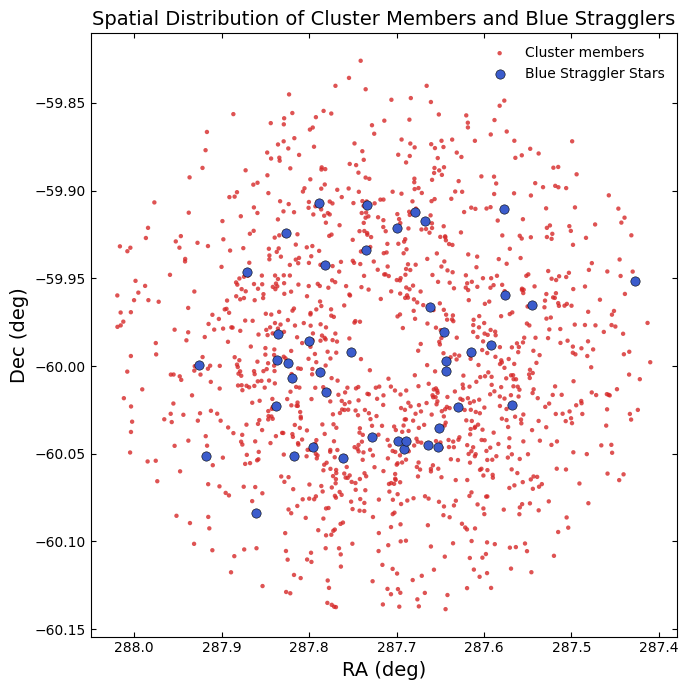

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Cluster member stars
members = pd.read_csv("/content/NGC6752_Memeberdata.csv")

# Blue Straggler stars
bss = pd.read_csv("/content/BSS_NGC6752_FINAL")

ra_m  = members["ra"]
dec_m = members["dec"]

ra_b  = bss["ra"]
dec_b = bss["dec"]

# ==============================
# PLOT
# ==============================
plt.figure(figsize=(7, 7))

# Cluster members (background)
plt.scatter(
    ra_m, dec_m,
    s=10,
    c="#D62828",      # soft blue
    alpha=0.8,
    edgecolors="none",
    label="Cluster members"
)

# Blue Stragglers (highlighted)
plt.scatter(
    ra_b, dec_b,
    s=45,
    c="#3B5CCC",      # deep red
    edgecolors="black",
    linewidths=0.4,
    label="Blue Straggler Stars"
)

# ==============================
# AXES & STYLE
# ==============================
plt.xlabel("RA (deg)", fontsize=14)
plt.ylabel("Dec (deg)", fontsize=14)

plt.gca().invert_xaxis()
plt.tick_params(direction="in", top=True, right=True)

plt.legend(frameon=False)
plt.title("Spatial Distribution of Cluster Members and Blue Stragglers", fontsize=14)

plt.tight_layout()


plt.savefig("RA_DEC_BSS_Distribution.pdf", dpi=300)
plt.savefig("RA_DEC_BSS_Distribution.png", dpi=300)
plt.show()
